## PRICE ESTIMATION ## 
## Features: Audience credibility, Engagement rate, Follower count, Impressions (views), Reach
## Target variable: Price ##

In [2]:
pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# ===================================================
# Influencer Pricing Prediction – Linear Regression (Excel, only Reels)
# Dataset: reel_preise_de_influencer.xlsx
# ===================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

df = pd.read_excel("/Users/katiamogan/Downloads/reel_preise_de_influencer.xlsx")

In [5]:
print("Data overview:\n", df.head())
print("\nMissing value (per column):\n", df.isna().sum())

Data overview:
                   ig_name country  follower_count  reel_price  \
0              lyssi_xcii      de           98378      2600.0   
1  akte_x_der_influencer_      de          126560      1000.0   
2                edoschxx      de          605479      1000.0   
3         marble.interior      de           81373       500.0   
4               Shoppasel      de          356404       600.0   

   audience_credibility engagement_rate  avg_views_reel  avg_reach_reel  
0                  55.9            1.66           53700           45400  
1                  90.2            0.77          150000          145000  
2                  74.5            0.68          394000          331000  
3                  74.6            19.5           24200           20500  
4                  78.9             0.7          337000          283000  

Missing value (per column):
 ig_name                 0
country                 0
follower_count          0
reel_price              2
audience_credib

In [7]:
# Proof relevant column: 
expected_cols = [
    "ig_name", "country", "follower_count", "audience_credibility",
    "engagement_rate", "avg_views_reel", "avg_reach_reel", "reel_price"
]
missing_cols = [c for c in expected_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Fehlende Spalten in der Excel-Datei: {missing_cols}")

In [8]:
# Data Cleaning: 
# Null values
df = df.dropna(subset=["reel_price"]).copy()

In [10]:
# Numeric columns:
num_cols = ["follower_count", "audience_credibility", "engagement_rate",
            "avg_views_reel", "avg_reach_reel"]

for col in num_cols:
    # convert number formatting 
    df[col] = df[col].astype(str).str.replace(",", ".").str.strip()
    df[col] = pd.to_numeric(df[col], errors="coerce")  

# Replace missing values with median:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [11]:
# Delete ig_name (high cardinality):
df = df.drop(columns=["ig_name"])

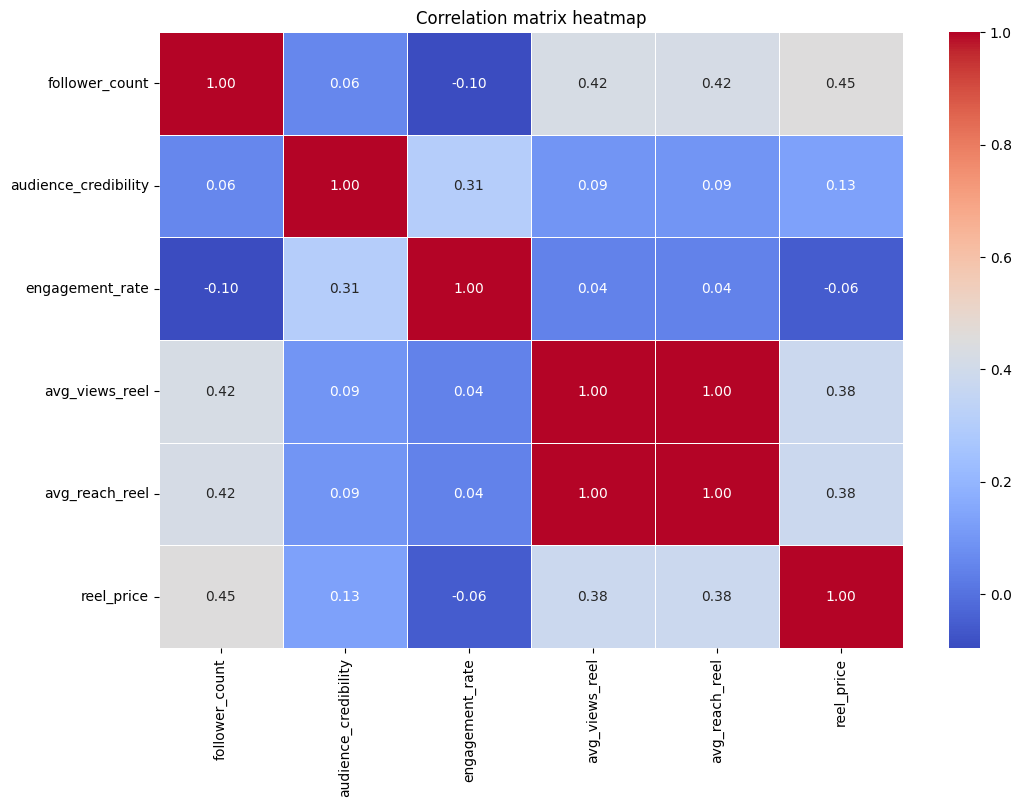

In [13]:
import pandas as pd 
cols = [
    'follower_count',
    'audience_credibility',
    'engagement_rate',
    'avg_views_reel',
    'avg_reach_reel',
    'reel_price'  
]

# Correlation matrix
corr_matrix = df[cols].corr()

# Visualize matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix heatmap")
plt.show()


In [14]:
# Log-Transformation (to reduce data asymmetry)
for col in ["follower_count", "avg_views_reel", "avg_reach_reel"]:
    df[f"log_{col}"] = np.log1p(df[col])

In [15]:
# Show column names
print(df.columns.tolist())

['country', 'follower_count', 'reel_price', 'audience_credibility', 'engagement_rate', 'avg_views_reel', 'avg_reach_reel', 'log_follower_count', 'log_avg_views_reel', 'log_avg_reach_reel']


In [18]:
# Feature-Definition
features = [
    "log_follower_count",
    "log_avg_reach_reel"
]

In [19]:
# Existing feature
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    raise ValueError(f"Missing feature-columns after preprocessing: {missing_features}")

X = df[features]
y = df["reel_price"]

print(f"\nChosen Features ({len(features)}):\n", features)


Chosen Features (2):
 ['log_follower_count', 'log_avg_reach_reel']


In [20]:
# DATA SPLIT 
def train_linear_regression(X, y, label="Reels"):
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n--- Results for {label} ---")
    print(f"R²:  {r2:.3f}")
    print(f"MAE: {mae:.2f}")

    # Coefficients
    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    }).sort_values(by="Coefficient", ascending=False)

    print("\nCoefficients (desc):")
    print(coef_df)

    # Plot
    plt.figure(figsize=(8, max(4, 0.25 * len(coef_df))))
    sns.barplot(x="Coefficient", y="Feature", data=coef_df)
    plt.title(f"Linear Regression – {label} (Coefficients)")
    plt.tight_layout()
    plt.show()

    # Output
    return model, scaler, r2, mae, coef_df


--- Results for Reels ---
R²:  0.252
MAE: 649.83

Coefficients (desc):
              Feature  Coefficient
0  log_follower_count   294.651413
1  log_avg_reach_reel   248.773365


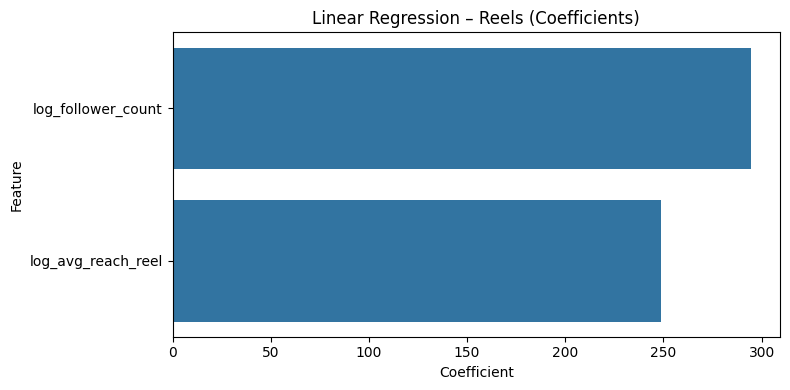

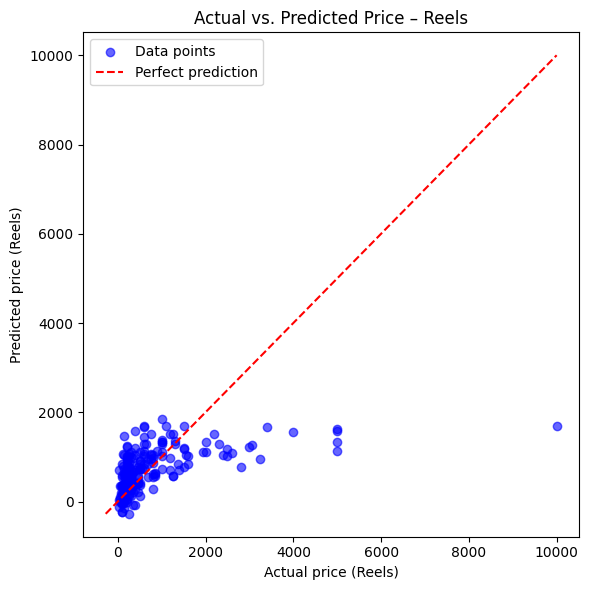

In [24]:
# Train model
model, scaler, r2, mae, coef_df = train_linear_regression(X, y, label="Reels")

# Actual vs. predicted values
X_scaled_full = scaler.transform(X)
y_pred_full = model.predict(X_scaled_full)

# Define limits for the y = x line
min_val = min(y.min(), y_pred_full.min())
max_val = max(y.max(), y_pred_full.max())

plt.figure(figsize=(6, 6))

plt.scatter(y, y_pred_full, alpha=0.6, color="blue", label="Data points")

# Line y = x (perfect prediction)
plt.plot([min_val, max_val], [min_val, max_val],
         color="red", linestyle="--", label="Perfect prediction")

plt.xlabel("Actual price (Reels)")
plt.ylabel("Predicted price (Reels)")
plt.title("Actual vs. Predicted Price – Reels")
plt.legend()
plt.tight_layout()
plt.show()

Linear regression does not model influencer pricing well.
This is typical because:
* Prices are highly nonlinear
* Two influencers with the same number of followers can charge very different prices
* Factors such as brand fit or influencer tier are missing from your feature matrix
* Influencers strongly differentiate between Reels and Stories in terms of production effort (workload, editing, camera quality, etc.)

/var/folders/7d/15kz148j36531h29_n069qhw0000gn/T/ipykernel_15750/3946554503.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/7d/15kz148j36531h29_n069qhw0000gn/T/ipykernel_15750/3946554503.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa


=== Reel Pricing Model ===
Best Params: {'model__n_estimators': 400, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': None}
R²:  0.292
MAE: 580.37 €


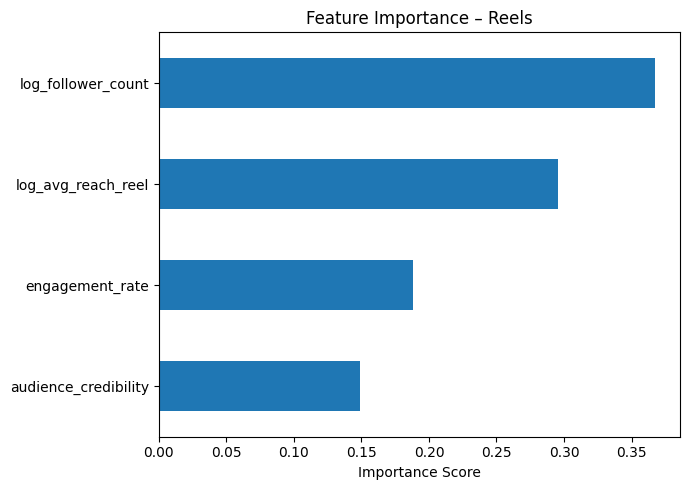

In [29]:
# =============================================
# Influencer Pricing Model – Reels only
# Random Forest + Hyperparameter Optimization
# =============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

# ------------------------------------------------
# 1. Load data
# ------------------------------------------------
df = pd.read_excel("/Users/katiamogan/Downloads/reel_preise_de_influencer.xlsx")

# ------------------------------------------------
# 2. Data cleaning
# ------------------------------------------------
df = df.dropna(subset=["reel_price"]).copy()

num_cols = [
    "follower_count",
    "audience_credibility",
    "engagement_rate",
    "avg_views_reel",
    "avg_reach_reel",
]

# Convert number formatting
for col in num_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill numeric NaNs with median
for col in num_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

# Drop high-cardinality identifier
if "ig_name" in df.columns:
    df.drop(columns=["ig_name"], inplace=True)

# ------------------------------------------------
# 3. Feature engineering
# ------------------------------------------------
for col in ["follower_count", "avg_views_reel", "avg_reach_reel"]:
    if col in df.columns:
        df[f"log_{col}"] = np.log1p(df[col])

features = [
    f for f in [
        "log_follower_count",
        "log_avg_reach_reel",
        "audience_credibility",
        "engagement_rate"
    ]
    if f in df.columns
]

if not features:
    raise ValueError("No valid features found. Check column names and transformations.")

X = df[features]
y = df["reel_price"]

# ------------------------------------------------
# 4. Train / test split
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------
# 5. Model + Hyperparameter optimization
# ------------------------------------------------
pipe = Pipeline([
    ("model", RandomForestRegressor(random_state=42))
])

param_distributions = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [5, 10, 15, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    random_state=42
)

# ------------------------------------------------
# 6. Training
# ------------------------------------------------
search.fit(X_train, y_train)
best_model = search.best_estimator_

# ------------------------------------------------
# 7. Evaluation
# ------------------------------------------------
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Reel Pricing Model ===")
print("Best Params:", search.best_params_)
print(f"R²:  {r2:.3f}")
print(f"MAE: {mae:.2f} €")

# ------------------------------------------------
# 8. Feature importance
# ------------------------------------------------
rf = best_model.named_steps["model"]
importance = pd.Series(
    rf.feature_importances_, index=X.columns
).sort_values(ascending=True)

plt.figure(figsize=(7, 5))
importance.plot(kind="barh")
plt.title("Feature Importance – Reels")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


Interpretation of the Model Results
Best Parameters
The Random Forest model selected:
400 trees
max_depth = None → trees grow deep (hardly any restriction)
min_samples_split = 5 → slightly more conservative to reduce overfitting
min_samples_leaf = 4 → smooths predictions
max_features = "sqrt" → typical choice for robust models
This means:
The model allows high complexity (deep trees) while actively preventing strong overfitting (leaf = 4).
Model Performance
R² = 0.292
The model explains 29% of the price variance.
For influencer & creator pricing, this is typically low, because real prices are extremely volatile and subjective.
An R² below 0.30 indicates that the model captures some signal, but a large part of pricing behavior remains unexplained by the available features.
Typical reasons:
Influencers set prices strategically, not linearly based on reach.
Many important factors are missing:
Category (fashion / food / beauty?)
Brand fit
Campaign quality
Conversion power
B2B vs. B2C markets
Exclusivity
Frequency of collaborations
MAE = €580.40
This means that the average prediction error is ±€580.
Example:
If a Reel should cost €1,000, the model might predict €420 or €1,580.
This is not unusual for creator pricing.
Influencer Reel prices are highly unevenly distributed:
Nano influencers: €50–200
Mid-tier: €300–1,500
Macro: €2,000–10,000
Celebrities: €20,000–100,000
With such wide ranges, errors of €500–800 are very normal.
4. Summary
The model does detect a real pattern (R² ≈ 0.29).
The chosen hyperparameters are reasonable.
MAE (≈ €580) is realistically good for this market segment.
What the result means
The available features explain only part of the price.
A large portion of pricing is unstructured, subjective, or missing from the dataset.
5. Recommendations for Improvement
Creator-Level Features
Content quality / production level
Niche / category
Posting frequency
Number of booked campaigns per month
Audience Features
Percentage of followers from DE / AT / CH
Audience age & gender
Audience authenticity (not just a credibility score)
Commercial Features
Average historical campaign prices
Brand-fit scores
Seasonality / timing
Exclusivity clauses

In [34]:
import pandas as pd
import numpy as np

# ------------------------------------------------
# 1) Load data
# ------------------------------------------------
df = pd.read_excel("/Users/katiamogan/Downloads/reel_preise_de_influencer.xlsx").copy()

# ------------------------------------------------
# 2) Number formatting
# ------------------------------------------------
num_cols = [
    "follower_count",
    "audience_credibility",
    "engagement_rate",
    "avg_views_reel",
    "avg_reach_reel",
    "reel_price",
]

for col in num_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ------------------------------------------------
# 3) Replace missing values with median
# ------------------------------------------------
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median(skipna=True))

# ------------------------------------------------
# 4) Remove invalid reach / view values
# ------------------------------------------------
df["avg_reach_reel"] = df["avg_reach_reel"].replace(0, np.nan)
df["avg_views_reel"] = df["avg_views_reel"].replace(0, np.nan)

# ------------------------------------------------
# 5) CPM / CPV calculation
# ------------------------------------------------
# CPM: € per 1,000 reach
df["cpm_reach"] = df["reel_price"] / (df["avg_reach_reel"] / 1000)

# CPV: € per 1,000 views
df["cpv_views_per_1000"] = df["reel_price"] / (df["avg_views_reel"] / 1000)

# Remove infinite values
df["cpm_reach"] = df["cpm_reach"].replace([np.inf, -np.inf], np.nan)
df["cpv_views_per_1000"] = df["cpv_views_per_1000"].replace([np.inf, -np.inf], np.nan)

# ------------------------------------------------
# 6) Overall benchmarks
# ------------------------------------------------
benchmarks_overall = {
    "cpm_median": float(df["cpm_reach"].median(skipna=True)),
    "cpm_25pct": float(df["cpm_reach"].quantile(0.25)),
    "cpm_75pct": float(df["cpm_reach"].quantile(0.75)),
    "cpv_median_per1000": float(df["cpv_views_per_1000"].median(skipna=True)),
    "cpv_25pct_per1000": float(df["cpv_views_per_1000"].quantile(0.25)),
    "cpv_75pct_per1000": float(df["cpv_views_per_1000"].quantile(0.75)),
}

print("Benchmarks (CPM / CPV per 1,000):")
print(benchmarks_overall)

# ------------------------------------------------
# 7) Benchmarks by follower tier (optional)
# ------------------------------------------------
bins = [0, 10_000, 50_000, 250_000, 1_000_000, np.inf]
labels = [
    "nano_<=10k",
    "micro_10k-50k",
    "mid_50k-250k",
    "macro_250k-1M",
    "celebrity_>1M",
]

df["follower_tier"] = pd.cut(
    df["follower_count"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

tier_stats = (
    df.groupby("follower_tier")
    .agg(
        n=("reel_price", "count"),
        median_reel_price=("reel_price", "median"),
        median_cpm_reach=("cpm_reach", "median"),
        median_cpv_per1000=("cpv_views_per_1000", "median"),
    )
    .reset_index()
)

print("\nBenchmarks by follower tier:")
print(tier_stats)

# ------------------------------------------------
# 8) Price estimation functions
# ------------------------------------------------
def estimate_price_by_reach(
    expected_reach,
    cpm=None,
    cpm_mode="median",
    engagement_factor=1.0,
    credibility_factor=1.0,
):
    """
    Estimate price based on expected reach.
    - expected_reach: expected reach (absolute number)
    - cpm: optional CPM (€ per 1,000 reach)
    - cpm_mode: "median", "25pct", "75pct" or numeric string
    - engagement_factor: multiplicative factor (e.g. 1.2 for strong engagement)
    - credibility_factor: multiplicative factor (e.g. 1.1 for high credibility)
    """

    if cpm is None:
        if cpm_mode == "median":
            cpm = benchmarks_overall["cpm_median"]
        elif cpm_mode == "25pct":
            cpm = benchmarks_overall["cpm_25pct"]
        elif cpm_mode == "75pct":
            cpm = benchmarks_overall["cpm_75pct"]
        else:
            cpm = float(cpm_mode)

    if np.isnan(cpm):
        raise ValueError("Baseline CPM is NaN. Check dataset.")

    price = (
        cpm * (expected_reach / 1000)
        * engagement_factor
        * credibility_factor
    )

    return float(price)


def estimate_price_by_views(
    expected_views,
    cpv_per1000=None,
    cpv_mode="median",
    engagement_factor=1.0,
    credibility_factor=1.0,
):
    """
    Estimate price based on expected views (CPV per 1,000 views).
    - expected_views: expected number of views
    - cpv_per1000: optional CPV (€ per 1,000 views)
    """

    if cpv_per1000 is None:
        if cpv_mode == "median":
            cpv_per1000 = benchmarks_overall["cpv_median_per1000"]
        elif cpv_mode == "25pct":
            cpv_per1000 = benchmarks_overall["cpv_25pct_per1000"]
        elif cpv_mode == "75pct":
            cpv_per1000 = benchmarks_overall["cpv_75pct_per1000"]
        else:
            cpv_per1000 = float(cpv_mode)

    if np.isnan(cpv_per1000):
        raise ValueError("Baseline CPV is NaN. Check dataset.")

    price = (
        cpv_per1000 * (expected_views / 1000)
        * engagement_factor
        * credibility_factor
    )

    return float(price)

# ------------------------------------------------
# 9) Examples
# ------------------------------------------------
price_example_1 = estimate_price_by_reach(
    expected_reach=50_000,
    cpm_mode="median",
    engagement_factor=1.20,
    credibility_factor=1.10,
)

print(
    f"\nEstimated price (Reach 50k, +20% engagement, +10% credibility): "
    f"{price_example_1:.2f} €"
)

price_example_2 = estimate_price_by_views(
    expected_views=30_000,
    cpv_mode="median",
)

print(
    f"Estimated price (Views 30k, baseline CPV median): "
    f"{price_example_2:.2f} €"
)


Benchmarks (CPM / CPV per 1,000):
{'cpm_median': 22.058823529411764, 'cpm_25pct': 8.24095106414498, 'cpm_75pct': 46.29728860786626, 'cpv_median_per1000': 18.975332068311193, 'cpv_25pct_per1000': 7.088586393812047, 'cpv_75pct_per1000': 39.03586461725996}

Benchmarks by follower tier:
   follower_tier   n  median_reel_price  median_cpm_reach  median_cpv_per1000
0     nano_<=10k  30              162.5         11.688312           10.964965
1  micro_10k-50k  97              250.0         28.636884           24.271845
2   mid_50k-250k  71              600.0         18.932039           17.492711
3  macro_250k-1M  13             1250.0         10.593220            8.928571
4  celebrity_>1M   0                NaN               NaN                 NaN

Estimated price (Reach 50k, +20% engagement, +10% credibility): 1455.88 €
Estimated price (Views 30k, baseline CPV median): 569.26 €


/var/folders/7d/15kz148j36531h29_n069qhw0000gn/T/ipykernel_15750/1301601664.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("follower_tier")
